<a href="https://colab.research.google.com/github/tawsifkamal/Deep-Q-Learning/blob/main/DeepQ_Learning_CartPole_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Learning with Open AI Gym's Cart Pole Environment

In this notebook, an implementation of the deep-q-learning algorithm will be show step-by-step in order to balance a cartpole given that the AI can move right or left. The agent has to accumilate a reward of 195+ points across 100 episodes in order to win the game. However, because of the restraints of Deep-Q-Learning, the highest reward attained by this model is around 187. Through parameter tuning, more optimal results can be achieved.

To learn more about Deep-Q-Learning, check out my medium article where I provide an intuitive approach to understand this algorithm:

 [An Intuitive Approach to Q-learning](https://medium.com/swlh/an-intuitive-approach-to-q-learning-p1-acedb6dff968)


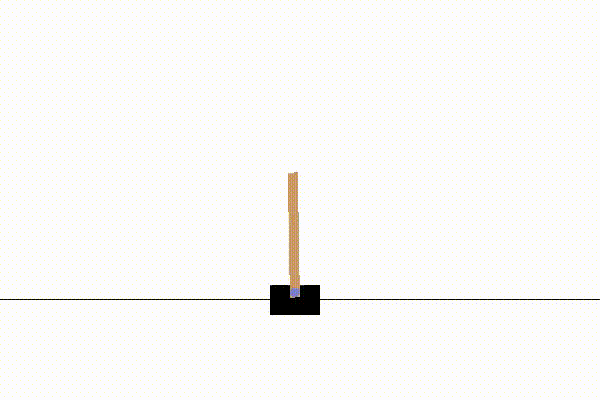

## Importing the libraries

In [3]:
%matplotlib inline 
import gym 
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from collections import namedtuple
from itertools import count
from PIL import Image 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

# Installing the Required Dependancies to Render Environment

In [5]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 10 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 993 kB in 1s (1,533 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-1) ...
S

In [6]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [7]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

## Setting up our algorithms -> Classes in function

In [8]:
class DQN(nn.Module): 
  def __init__(self, img_height, img_width):
    super().__init__()

    # 3 corresponds to 3 colour channels in RGB images that will be received by the NN as inputs 
    self.fc1 = nn.Linear(in_features=img_height * img_width * 3, out_features=24)
    self.fc2 = nn.Linear(in_features = 24, out_features = 32)
    self.out = nn.Linear(in_features = 32, out_features = 2)

  def forward(self, t): 
    t = t.flatten(start_dim=1)
    t = F.relu(self.fc1(t))
    t = F.relu(self.fc2(t))
    t = self.out(t)
    return t 


## Creating the Experience Tuple 

In [9]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [10]:
e = Experience(2, 3, 1, 4)

In [11]:
print(e)

Experience(state=2, action=3, next_state=1, reward=4)


In [12]:
class ReplayMemory():
  def __init__(self, capacity):
    self.capacity  = capacity # defining the capacity for the replay memory lsit 
    self.memory = []
    self.push_count = 0
  
  def push(self, experience):
    if len(self.memory) < self.capacity: # appending the experience if the lenght of replay memory is less than the capacity that is set 
      self.memory.append(experience)
    else:
      #overriding the earliest experience in replay memory with newest experience
      self.memory[self.push_count % self.capacity] = experience # 0, 1, 2, 3, 4, 5 and then repeat
    self.push_count += 1 

  def sample(self, batch_size): 
    return random.sample(self.memory, batch_size)
  
  def can_provide_sample(self, batch_size):
    return len(self.memory) >= batch_size

## Defining the Epsilon Greedy Strategy 

This is the strategy is that used for our agent to select an action through the exploration-exploitation trade-off. In this class, the exploration rate for the current time step will be returned

In [13]:
class EpsilonGreedyStrategy():
  def __init__(self, start, end, decay):
    self.start = start 
    self.end = end 
    self.decay = decay

  def get_exploration_rate(self, current_step):
    return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

## Defining the Agent Class

In [14]:
class Agent():
  def __init__(self, strategy, num_actions, device):
    self.current_step = 0
    self.strategy = strategy
    self.num_actions = num_actions
    
  def select_action(self, state, policy_net):
    rate = strategy.get_exploration_rate(self.current_step)
    self.current_step += 1 

    if rate > random.random():
      action = random.randrange(self.num_actions)
      return torch.tensor([action]).to(device) # explore 
      
    else:
      with torch.no_grad():
        return policy_net(state).argmax(dim=1).to(device) # exploit # choose the output (qvalues)action with the highest q-value


# Defining the CartPoleEnvManager

This class will contain all of the environment methods and attributes. Including pre-existing gym functionalities, this class also includes image processing for our given states, choosing actions, and extra wrapper functions.


In [15]:
class CartPoleEnvManager():
  def __init__(self, device):
    self.device = device
    self.env = gym.make('CartPole-v0').unwrapped 
    self.env.reset()
    self.current_screen = None 
    self.done = False 
  
  def reset(self):
    self.env.reset()
    self.current_screen = None 
  
  def close(self):
    self.env.close()
  
  def render(self, mode='human'):
    return self.env.render(mode)
  
  def num_actions_available(self):
    return self.env.action_space.n 

  def take_action(self, action): # action being passed will be a tensor 
    _, reward, self.done, _ = self.env.step(action.item()) # .item() returns the tensor value as a standard python number, which is expected by env.step(x)
    return torch.tensor([reward], device = self.device) # tensor coming in and tensor coming out; need our reward to be a tensor for later purposes 
  
  def just_starting(self):
    return self.current_screen is None # returns true when current screen is one AKA episode is start, or returns false 
  
  def get_state(self):
    if self.just_starting() or self.done: # if self.just_starting() == True, then we don't have any previous screen to compare, therefore a starting state == a fully black screen
      self.current_screen = self.get_processed_screen()
      black_screen = torch.zeros_like(self.current_screen)
      return black_screen
    else:
      s1 = self.current_screen
      s2 = self.get_processed_screen()
      self.current_screen = s2 #s2 becomes current screen and s1 becomes previous screen
      return s2 - s1
    
  def get_screen_height(self):
    screen = self.get_processed_screen()
    return screen.shape[2] #2 = height
    
  def get_screen_width(self):
     screen = self.get_processed_screen()
     return screen.shape[3] # 3 = width

  def get_processed_screen(self):
     screen = self.render('rgb_array').transpose((2, 0, 1)) # transposes this array into channels by height and by width
     screen = self.crop_screen(screen)
     return self.transform_screen_data(screen) # transposed, cropped, and transformed version of the original image is returned by the get_processed_screen method of our EnvManager

  def crop_screen(self, screen):
     screen_height = screen.shape[1] # getting the height, I thought screen.shape[2] == height????
     # strip off top and bottom
     top = int(screen_height * 0.4)
     bottom = int(screen_height * 0.8)
     screen = screen[:, top:bottom, :] # stripping off top 40 percent of original image and bottom 20 percent 
     return screen

  def transform_screen_data(self, screen):
     # Convert to float, rescale, convert to tensor 
     screen = np.ascontiguousarray(screen, dtype=np.float32) /255 # common image preprocessing for neural network input. Contiguosarray == returning all of the stored pixels in the screen as sequential pixels in the contiguous array
     screen = torch.from_numpy(screen) # convert numpy array to pytorch tensor 
     # use torchvision package to compose image transforms 
     resize = T.Compose([
                         T.ToPILImage(),
                         T.Resize((40, 90)), # 40 by 90 image 
                         T.ToTensor() # PIL image is then transformed to a tensor 
     ])
     return resize(screen).unsqueeze(0).to(self.device) # add a batch dimensions since processed image will be passed to DQN in batches 


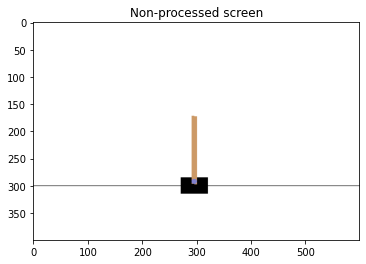

In [16]:
# Printing out Unprocessed screen
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen')
plt.show()

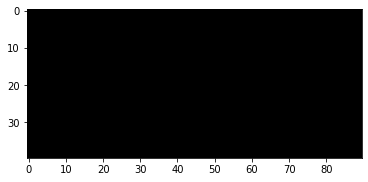

In [17]:
# Printing out the starting screen
screen = em.get_state()

plt.figure()
plt.imshow(screen.cpu().squeeze(0).permute(1, 2, 0), interpolation='none')
plt.show()

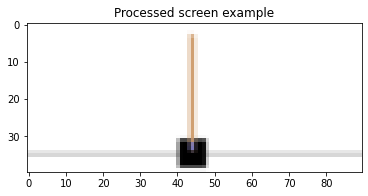

In [18]:
# Printing out the processed screen
screen = em.get_processed_screen()
plt.figure()
plt.imshow(screen.cpu().squeeze(0).permute(1, 2, 0), interpolation='none')
plt.title('Processed screen example')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


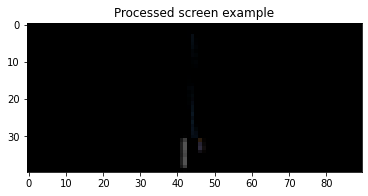

In [19]:
# Printing out the state after a certain number of episodes have been ran
em.reset()
for i in range(6):
  em.take_action(torch.tensor([1]))
  screen = em.get_state()
  
plt.figure()
plt.imshow(screen.cpu().squeeze(0).permute(1, 2, 0), interpolation='none')
plt.title('Processed screen example')
plt.show()

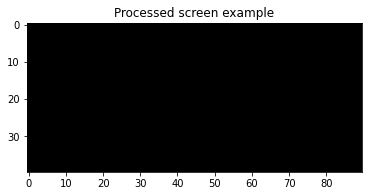

In [20]:
# printing out the sceen after the episode has been finished 
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.cpu().squeeze(0).permute(1, 2, 0), interpolation='none')
plt.title('Processed screen example')
plt.show()

# Plot the moving average of rewards across 100 episodes 
Moving average period values 
plots the duration of each episode as well as the one hundred episode moving average 
duration for episode is equivalent to the reward of the episode because for each time step the cart and pole env is alive, it will get a reward of one. 

In [21]:
def plot(values, moving_avg_period):
  plt.figure(2)
  plt.clf()
  plt.title('Training...')
  plt.xlabel('Episode')
  plt.ylabel('Duration')
  plt.plot(values) # values == episode durations

  moving_avg = get_moving_average(moving_avg_period, values)
  plt.plot(moving_avg)
  plt.pause(0.001)
  print('Episode', len(values), '\n', moving_avg_period, 'episode moving avg:', moving_avg[-1])
  if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values): # i.e 100 episode moving average 
  values = torch.tensor(values, dtype=torch.float)
  if len(values) >= period: 
    moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
    moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
    return moving_avg.numpy()
  
  else:
    moving_avg = torch.zeros(len(values))
    return moving_avg.numpy()

## Defining the global Parameters for our Deep-Q-Learning Class

In [22]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10 # update target networks weights to match policy networks weights every ten episodes
memory_size = 100000 # capacity of the replay memory 
lr = 0.001 
num_episodes = 1000

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict()) # setting the wieghts of target net to be equal to the wieghts of the policy net 
target_net.eval()  # not in training mode, only used for inferencing
optimizer = optim.Adam(params=policy_net.parameters(), lr = lr) # using the Adam optimizer from the nn.optim class



## Extracting each features from the Experience tuple

In [23]:
# extract tensors function (extract from given experience batch)
def extract_tensors(experiences): # accepts batch of experience
  batch = Experience(*zip(*experiences)) # contain numerically readable values from the experience list

  t1 = torch.cat(batch.state)
  t2 = torch.cat(batch.action)
  t3 = torch.cat(batch.next_state)
  t4 = torch.cat(batch.reward)

  return t1, t2, t3, t4 


## Extracting the Q-values from Policy net and Target net

In [24]:
class QValues():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  @staticmethod
  def get_current(policy_net, states, actions): # state-action pairs sampled from replay memory. so they correspond with each other 
    return policy_net(states).gather(dim = 1, index = actions.unsqueeze(-1)) # predicted q-values for policy net 

  @staticmethod 
  def get_next(target_net, next_states):
    final_state_locations = next_states.flatten(start_dim = 1).max(dim=1)[0].eq(0).type(torch.bool) # final state == True; non-final state == False 
    non_final_state_locations = (final_state_locations == False) # true for non-final state; false for final state
    non_final_states = next_states[non_final_state_locations]
    batch_size = next_states.shape[0]
    values = torch.zeros(batch_size).to(QValues.device)
    values[non_final_state_locations] = target_net(non_final_states).max(dim = 1)[0].detach() # 0s for the q-values for any final state and contains target_nets maximum predicted q_values across all actions for each_non_final state
    return values

## Training our agent and printing out rewards

In [25]:
episode_durations = []
for episode in range(num_episodes):
  
  state = em.get_state() 

  for timestep in count():
    action = agent.select_action(state, policy_net) 
    next_state = em.get_state()
    memory.push(Experience(state, action, next_state, reward))


    if memory.can_provide_sample(batch_size):
      experiences = memory.sample(batch_size)
      states, actions, next_states, rewards = extract_tensors(experiences)

      current_q_values = QValues.get_current(policy_net, states, actions) # get current return q-values for any given state action pairs predicted by the policy network
      next_q_values = QValues.get_next(target_net, next_states) # maximum q-values for the for the next states for the best corresponding actions 
      target_q_values = (next_q_values * gamma) + rewards # bellman equation basically 

      loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # current q-values of the current state - the optimal q-values in the next state 
      loss.backward() # calculates gradient of loss function with respect to all weigths and biases of the policy net 
      optimizer.step() # gradient descent 
    

      if em.done:
        episode_durations.append(timestep)
        plot(episode_durations, 100)
        break
      
      if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())


em.close()


NameError: ignored